# Libraries Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from google.colab import drive

print(torch.__version__)

1.13.0+cu116


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Datasets

In [ ]:
parent_folder = '/content/gdrive/MyDrive/HC18'
data_folder = '/content/gdrive/MyDrive/HC18/data'

In [ ]:
class HC18(Dataset):
    def __init__(self, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'training_set_pixel_size_and_HC.csv'))
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)
    
    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
        else:
            imx_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        # We will use resize, tensorlize, and normalize in the following cell
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
with open(os.path.join(parent_folder, 'train_data.pickle'), 'rb') as f:
    train_data = pickle.load(f)
with open(os.path.join(parent_folder, 'validation_data.pickle'), 'rb') as f:
    validation_data = pickle.load(f)

# Dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2)

# Build the Model

In [ ]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        try: 
            psi = self.relu(g1+x1)
        except:
            psi = self.relu(F.pad(g1,(1,0,1,0)) + x1)
        psi = self.psi(psi)
        return x * psi


class AttU_Net(nn.Module):
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=64)
        self.Conv2 = conv_block(ch_in=64, ch_out=128)
        self.Conv3 = conv_block(ch_in=128, ch_out=256)
        self.Conv4 = conv_block(ch_in=256, ch_out=512)
        self.Conv5 = conv_block(ch_in=512, ch_out=1024)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, F.pad(d5,(1,0,1,0))), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, F.pad(d4,(1,0,1,0))), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.sigmoid(d1)

        return d1

In [ ]:
model = AttU_Net(1, 1)
model.cuda()
print("Model Loaded to GPU")

Model Loaded to GPU


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
    return 1 -(dice_index(y_predict, y_train))

# Only train the model if you want to retrain, scroll down to load the pre-trained model

In [ ]:
epochs = 20

train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0  
    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].cuda()
        y_train = sample_batched['annotation'].cuda()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if ith_batch % 50 == 0:
            print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
        train_running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                X_val = sample_batched['image'].cuda()
                y_val = sample_batched['annotation'].cuda()
                y_out = model(X_val)
                out_val = (y_out + 0.5).int().float()
                val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
                validation_running_loss += val_loss.item()
            print("================================================================================")
            print("Epoch {} completed".format(e + 1))

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            print("Average train loss is {}: ".format(train_epoch_loss))
            print("Average validation loss is {}".format(validation_epoch_loss))
            print("================================================================================")
            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)

    torch.cuda.empty_cache()

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

In [ ]:
torch.save(model, os.path.join(parent_folder, 'savedmodel/AttentionUNet.pt'))

# You can load a model instead

In [ ]:
model = torch.load(os.path.join(parent_folder, 'savedmodel/AttentionUNet.pt'))
model.to('cuda')
model.eval()

AttU_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

In [ ]:
def avg_dice_index(dataloader):
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            y_predict = (model(X_train) + 0.5).int().float()
            dice += dice_index(y_predict, y_train)
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.9477168321609497

In [ ]:
avg_dice_index(train_loader)    #### Dice index of train data

0.940281867980957

In [ ]:
class HC18_test(Dataset):
    def __init__(self, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'test_set_pixel_size.csv'))
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(data_folder,'test_set_A', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample
tx_X = transforms.Compose([transforms.Resize((572, 572)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))])
test_data = HC18_test(transformX = tx_X)
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [ ]:
def im_converterX(tensor):
  image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy 
                                              # as we will need original later
  image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
  # print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image 
                                              # this also outputs (28, 28, 3) which seems important for plt.imshow
  image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
  return image

def im_converterY(tensor):
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1,2,0) 
  # print(image.shape)
  image = image * np.array((1, 1, 1)) 
  image = image.clip(0, 1) 
  return image

0 torch.Size([2, 1, 572, 572])


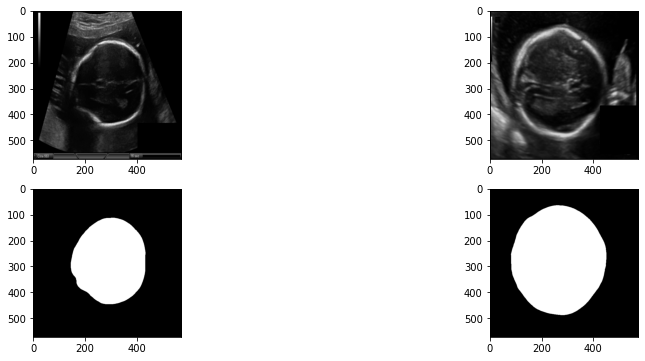

In [ ]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
       # print(335-ith_batch)
        
        file_names = sample['f_name']
        singh = transform(y_pred[0])
        torchvision.utils.save_image(singh, os.path.join(data_folder,'test_set_B', file_names[0]))
      print("Segmentation files written")

Segmentation files written
